## According to RFM ranking – An effective approach to customer segmentation research paper
### RFM plays an important role in customer segemntation recency, frequency and monetary value play a Significant role in in customer segmentation. Though the dataset given dosen't have these columns, I have featured engineered them into this notebook. Applying some dimensionality reduction and tradional ML algorithms, I was able to achieve a davies-Bouldin Index score of 0.0815.[Paper Link](https://www.sciencedirect.com/science/article/pii/*S1319157818304178*)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
transactions = pd.read_csv('/content/Transactions.csv', parse_dates=['TransactionDate'])
customers = pd.read_csv('/content/Customers.csv', parse_dates=['SignupDate'])

In [ ]:
transactions.describe()

,TransactionDate,Quantity,TotalValue,Price
count,1000,1000.000000,1000.000000,1000.00000
mean,2024-06-23 15:33:02.768999936,2.537000,689.995560,272.55407
min,2023-12-30 15:29:12,1.000000,16.080000,16.08000
25%,2024-03-25 22:05:34.500000,2.000000,295.295000,147.95000
50%,2024-06-26 17:21:52.500000,3.000000,588.880000,299.93000
75%,2024-09-19 14:19:57,4.000000,1011.660000,404.40000
max,2024-12-28 11:00:00,4.000000,1991.040000,497.76000
std,NaN,1.117981,493.144478,140.73639


Here we can see the last transaction date is **2024-12-28 11:00:00**. So we take it as the current date as latest transaction date

In [ ]:
last_date = datetime(2024, 12,28)

### Applying Initial Transformations

In [ ]:
data = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (last_date - x.max()).days,
    'TransactionID': 'count',
    'TotalValue': 'sum'
}).rename(columns={
    'TransactionDate': 'LastTrans',
    'TransactionID': 'TransactionCount',
    'TotalValue': 'totalSpend'
}).reset_index()

data

,CustomerID,LastTrans,TransactionCount,totalSpend
0,C0001,55,5,3354.52
1,C0002,24,4,1862.74
2,C0003,125,4,2725.38
3,C0004,4,8,5354.88
4,C0005,53,3,2034.24
...,...,...,...,...
194,C0196,12,4,4982.88
195,C0197,0,3,1928.65
196,C0198,84,2,931.83
197,C0199,62,4,1979.28


### In the above codecell we feature engineered LastTrans	TransactionCount	totalSpend to get a table of needed features

In [ ]:
merged_data = data.merge(customers.assign(Total_days=(last_date - customers['SignupDate']).dt.days), on='CustomerID')
merged_data


,CustomerID,LastTrans,TransactionCount,totalSpend,CustomerName,Region,SignupDate,Total_days
0,C0001,55,5,3354.52,Lawrence Carroll,South America,2022-07-10,902
1,C0002,24,4,1862.74,Elizabeth Lutz,Asia,2022-02-13,1049
2,C0003,125,4,2725.38,Michael Rivera,South America,2024-03-07,296
3,C0004,4,8,5354.88,Kathleen Rodriguez,South America,2022-10-09,811
4,C0005,53,3,2034.24,Laura Weber,Asia,2022-08-15,866
...,...,...,...,...,...,...,...,...
194,C0196,12,4,4982.88,Laura Watts,Europe,2022-06-07,935
195,C0197,0,3,1928.65,Christina Harvey,Europe,2023-03-21,648
196,C0198,84,2,931.83,Rebecca Ray,Europe,2022-02-27,1035
197,C0199,62,4,1979.28,Andrea Jenkins,Europe,2022-12-03,756


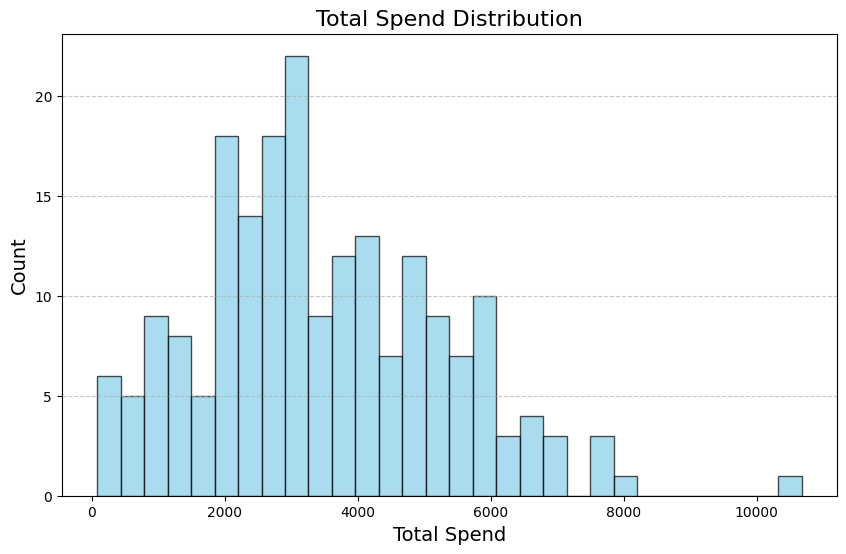

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(merged_data['totalSpend'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Total Spend Distribution', fontsize=16)
plt.xlabel('Total Spend', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Taking log to counter skewness

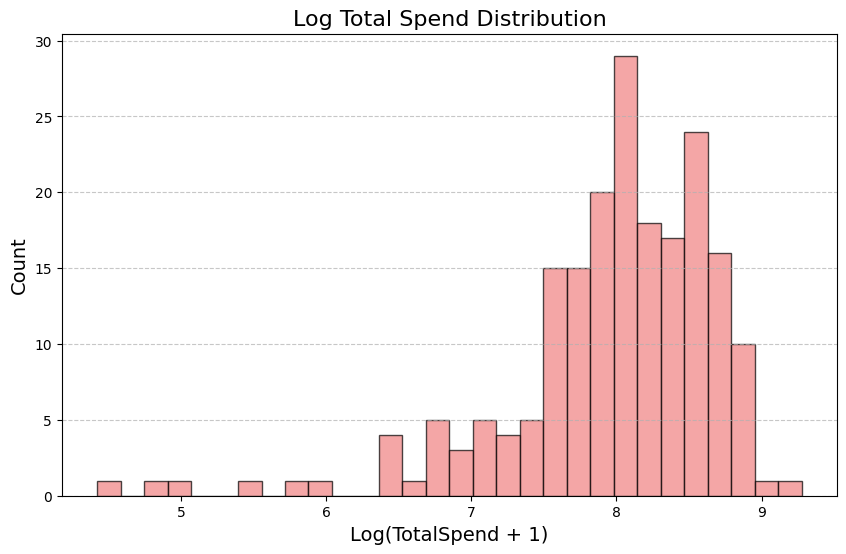

In [ ]:

log_total_spend = np.log1p(merged_data['totalSpend'])

plt.figure(figsize=(10, 6))
plt.hist(log_total_spend, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Log Total Spend Distribution', fontsize=16)
plt.xlabel('Log(TotalSpend + 1)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
merged_data = merged_data.assign(
    Trans_freq=merged_data['LastTrans'] / merged_data['TransactionCount'],
    Avg_spend=merged_data['totalSpend'] / merged_data['TransactionCount'],
    Log_totalSpend=np.log1p(merged_data['totalSpend'])
)


In [ ]:
merged_data

,CustomerID,LastTrans,TransactionCount,totalSpend,CustomerName,Region,SignupDate,Total_days,Trans_freq,Avg_spend,Log_totalSpend
0,C0001,55,5,3354.52,Lawrence Carroll,South America,2022-07-10,902,11.000000,670.904000,8.118362
1,C0002,24,4,1862.74,Elizabeth Lutz,Asia,2022-02-13,1049,6.000000,465.685000,7.530341
2,C0003,125,4,2725.38,Michael Rivera,South America,2024-03-07,296,31.250000,681.345000,7.910730
3,C0004,4,8,5354.88,Kathleen Rodriguez,South America,2022-10-09,811,0.500000,669.360000,8.585950
4,C0005,53,3,2034.24,Laura Weber,Asia,2022-08-15,866,17.666667,678.080000,7.618369
...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,12,4,4982.88,Laura Watts,Europe,2022-06-07,935,3.000000,1245.720000,8.513964
195,C0197,0,3,1928.65,Christina Harvey,Europe,2023-03-21,648,0.000000,642.883333,7.565094
196,C0198,84,2,931.83,Rebecca Ray,Europe,2022-02-27,1035,42.000000,465.915000,6.838223
197,C0199,62,4,1979.28,Andrea Jenkins,Europe,2022-12-03,756,15.500000,494.820000,7.590994


In [ ]:
data_processed = pd.get_dummies(merged_data, columns=['Region'])

features = ['LastTrans', 'TransactionCount', 'totalSpend', 'Total_days',
            'Avg_spend', 'Trans_freq', 'Log_totalSpend' , 'Region_Asia' , 'Region_Europe', 'Region_North America', 'Region_South America']

## Performing PCA for dimensionality reduction

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data_processed[features])

pca = PCA(n_components=3, random_state=42)
embedding = pca.fit_transform(scaled_features)


In [ ]:
def find_optimal_clusters(data, max_k=10):
    wcss = []
    db_scores = []
    silhouette_scores = []
    calinski_scores = []

    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        clusters = kmeans.fit_predict(data)

        wcss.append(kmeans.inertia_)
        db_scores.append(davies_bouldin_score(data, clusters))
        silhouette_scores.append(silhouette_score(data, clusters))
        calinski_scores.append(calinski_harabasz_score(data, clusters))

    return wcss, db_scores, silhouette_scores, calinski_scores

wcss, db_scores, silhouette_scores, calinski_scores = find_optimal_clusters(embedding)

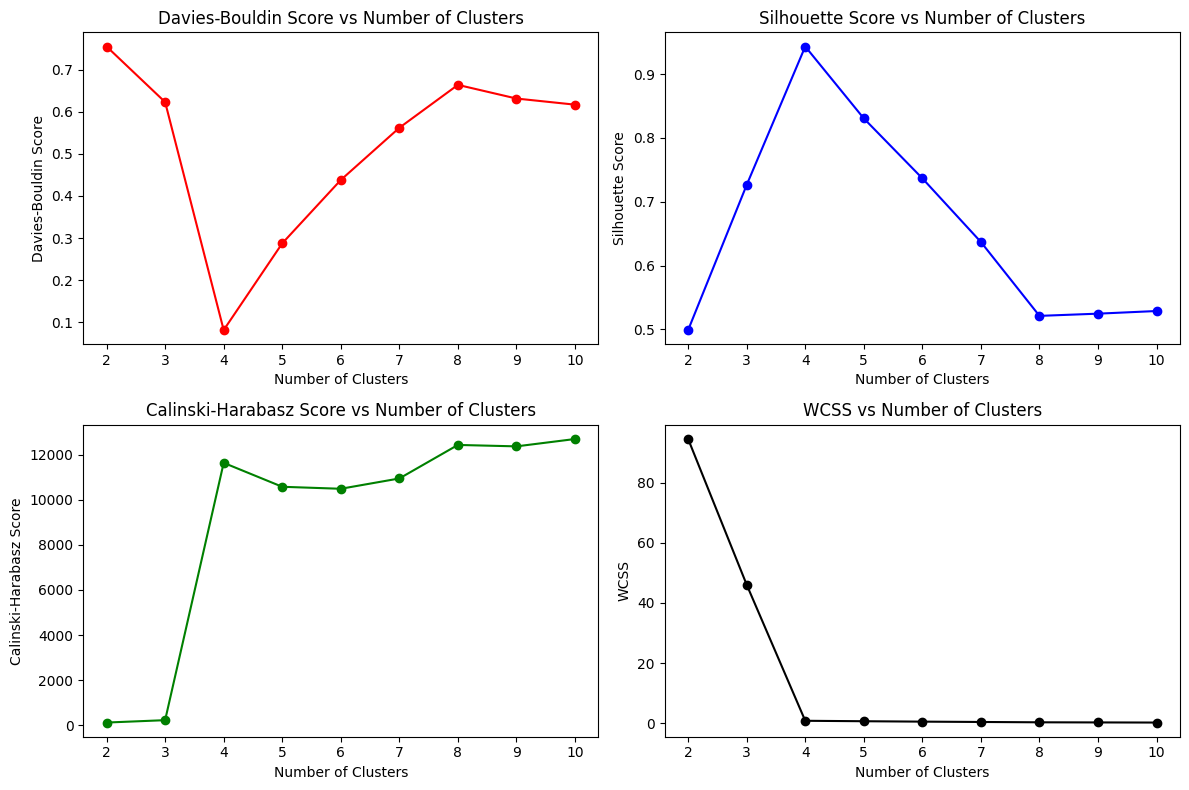

In [ ]:
def plot_cluster_metrics(wcss, db_scores, silhouette_scores, calinski_scores, max_k=10):
    clusters_range = range(2, max_k+1)

    plt.figure(figsize=(12, 8))

    # Plot Davies-Bouldin Score
    plt.subplot(2, 2, 1)
    plt.plot(clusters_range, db_scores, marker='o', color='red')
    plt.title('Davies-Bouldin Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')

    # Plot Silhouette Score
    plt.subplot(2, 2, 2)
    plt.plot(clusters_range, silhouette_scores, marker='o', color='blue')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    # Plot Calinski-Harabasz Score
    plt.subplot(2, 2, 3)
    plt.plot(clusters_range, calinski_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Score')

    plt.subplot(2, 2, 4)
    plt.plot(clusters_range, wcss, marker='o', color='black')
    plt.title('WCSS vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')

    plt.tight_layout()
    plt.show()

plot_cluster_metrics(wcss, db_scores, silhouette_scores, calinski_scores)


In the above Diagram we can see the best cluster value is at 4. So we choose 4 as cluster value

In [ ]:
print(f"Davies-Bouldin Score: {db_scores[2]:.4f}")
print(f"WCSS:                {wcss[2]:.2f}")
print(f"Silhouette Score:     {silhouette_scores[2]:.4f}")
print(f"Calinski-Harabasz Score: {calinski_scores[2]:.2f}")


Davies-Bouldin Score: 0.0814
WCSS:                0.83
Silhouette Score:     0.9433
Calinski-Harabasz Score: 11640.67


We got an impressive Davies-Bouldin Score of 0.0814 and a very high Calinski-Harabasz Score which indicates the model is performing really well with minimal overlapping



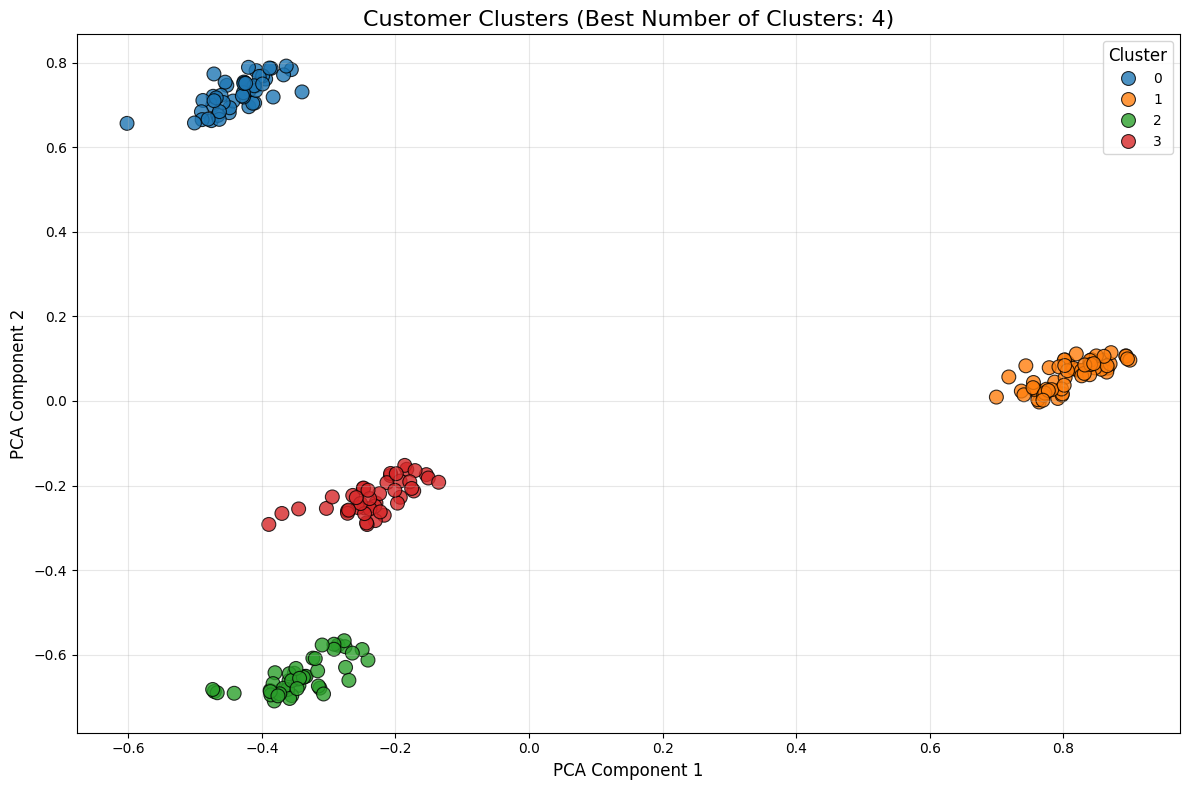

In [ ]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=20)
clusters = kmeans.fit_predict(embedding)

customer_features = pd.DataFrame(scaled_features, columns=features)
customer_features["Cluster"] = clusters
customer_features["PCA1"] = embedding[:, 0]
customer_features["PCA2"] = embedding[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_features,
    palette="tab10", s=100, edgecolor="black", alpha=0.8
)
plt.title(f"Customer Clusters (Best Number of Clusters: {optimal_clusters})", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Cluster", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

The above diagram has been plotted in 2D space but is really a 3D one. Hence we can get more insight and see clearly in 3D plot

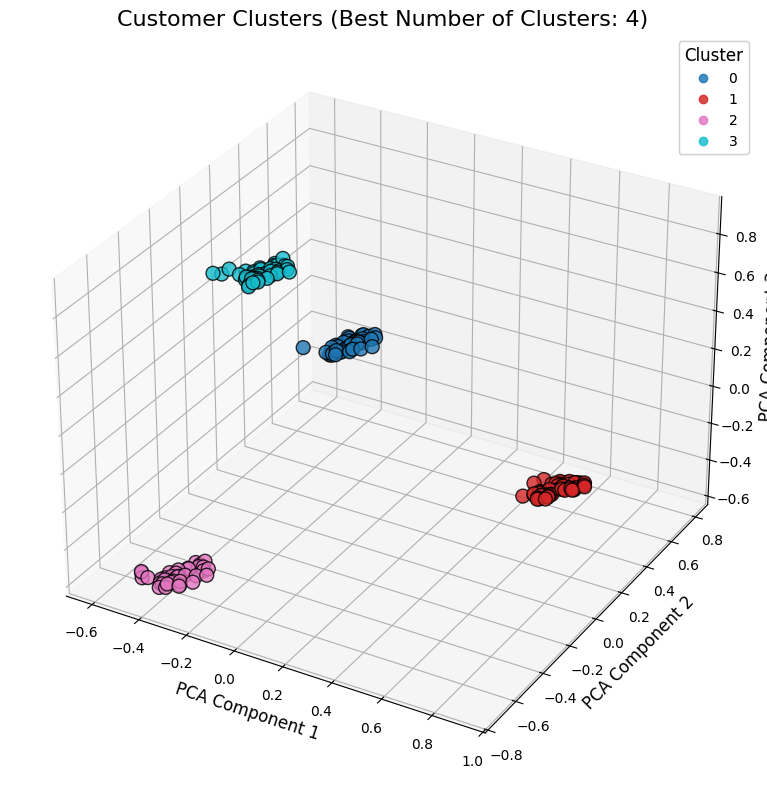

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

customer_features["PCA3"] = embedding[:, 2]

# Plot the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with 3D projection
scatter = ax.scatter(
    customer_features["PCA1"],
    customer_features["PCA2"],
    customer_features["PCA3"],
    c=customer_features["Cluster"],
    cmap="tab10",
    s=100,
    edgecolor="black",
    alpha=0.8
)

# Customize the plot
ax.set_title(f"Customer Clusters (Best Number of Clusters: {optimal_clusters})", fontsize=16)
ax.set_xlabel("PCA Component 1", fontsize=12)
ax.set_ylabel("PCA Component 2", fontsize=12)
ax.set_zlabel("PCA Component 3", fontsize=12)

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", fontsize=10, title_fontsize=12)
ax.add_artist(legend1)

# Show the plot
plt.tight_layout()
plt.show()


The 3D plot was able to form 4 clusters and they are well seperated

In [ ]:
data_processed['Cluster'] = clusters
data_processed

,CustomerID,LastTrans,TransactionCount,totalSpend,CustomerName,SignupDate,Total_days,Trans_freq,Avg_spend,Log_totalSpend,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,55,5,3354.52,Lawrence Carroll,2022-07-10,902,11.000000,670.904000,8.118362,False,False,False,True,1
1,C0002,24,4,1862.74,Elizabeth Lutz,2022-02-13,1049,6.000000,465.685000,7.530341,True,False,False,False,3
2,C0003,125,4,2725.38,Michael Rivera,2024-03-07,296,31.250000,681.345000,7.910730,False,False,False,True,1
3,C0004,4,8,5354.88,Kathleen Rodriguez,2022-10-09,811,0.500000,669.360000,8.585950,False,False,False,True,1
4,C0005,53,3,2034.24,Laura Weber,2022-08-15,866,17.666667,678.080000,7.618369,True,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,12,4,4982.88,Laura Watts,2022-06-07,935,3.000000,1245.720000,8.513964,False,True,False,False,0
195,C0197,0,3,1928.65,Christina Harvey,2023-03-21,648,0.000000,642.883333,7.565094,False,True,False,False,0
196,C0198,84,2,931.83,Rebecca Ray,2022-02-27,1035,42.000000,465.915000,6.838223,False,True,False,False,0
197,C0199,62,4,1979.28,Andrea Jenkins,2022-12-03,756,15.500000,494.820000,7.590994,False,True,False,False,0


In [ ]:
data_processed.head(10)

,CustomerID,LastTrans,TransactionCount,totalSpend,CustomerName,SignupDate,Total_days,Trans_freq,Avg_spend,Log_totalSpend,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,55,5,3354.52,Lawrence Carroll,2022-07-10,902,11.000000,670.904000,8.118362,False,False,False,True,1
1,C0002,24,4,1862.74,Elizabeth Lutz,2022-02-13,1049,6.000000,465.685000,7.530341,True,False,False,False,3
2,C0003,125,4,2725.38,Michael Rivera,2024-03-07,296,31.250000,681.345000,7.910730,False,False,False,True,1
3,C0004,4,8,5354.88,Kathleen Rodriguez,2022-10-09,811,0.500000,669.360000,8.585950,False,False,False,True,1
4,C0005,53,3,2034.24,Laura Weber,2022-08-15,866,17.666667,678.080000,7.618369,True,False,False,False,3
5,C0006,81,4,4227.57,Brittany Palmer,2024-01-07,356,20.250000,1056.892500,8.349619,False,False,False,True,1
6,C0007,124,3,2579.82,Paul Graves,2022-06-18,924,41.333333,859.940000,7.855862,True,False,False,False,3
7,C0008,10,10,4271.61,David Li,2024-01-13,350,1.000000,427.161000,8.359980,False,False,True,False,2
8,C0009,76,3,896.50,Joy Clark,2023-08-14,502,25.333333,298.833333,6.799613,False,True,False,False,0
9,C0010,41,4,1717.55,Aaron Cox,2022-12-15,744,10.250000,429.387500,7.449236,False,True,False,False,0
